In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima_model import ARMA
import statsmodels.api as sm
import itertools
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
data = pd.read_csv("Crime_Data.csv")
data.head()

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,Status,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON
0,190326475,03/01/2020 12:00:00 AM,03/01/2020 12:00:00 AM,2130,7,Wilshire,784,1,510,VEHICLE - STOLEN,...,AA,Adult Arrest,510.0,998.0,NaN,NaN,1900 S LONGWOOD AV,NaN,34.0375,-118.3506
1,200106753,02/09/2020 12:00:00 AM,02/08/2020 12:00:00 AM,1800,1,Central,182,1,330,BURGLARY FROM VEHICLE,...,IC,Invest Cont,330.0,998.0,NaN,NaN,1000 S FLOWER ST,NaN,34.0444,-118.2628
2,200320258,11/11/2020 12:00:00 AM,11/04/2020 12:00:00 AM,1700,3,Southwest,356,1,480,BIKE - STOLEN,...,IC,Invest Cont,480.0,NaN,NaN,NaN,1400 W 37TH ST,NaN,34.0210,-118.3002
3,200907217,05/10/2023 12:00:00 AM,03/10/2020 12:00:00 AM,2037,9,Van Nuys,964,1,343,SHOPLIFTING-GRAND THEFT ($950.01 & OVER),...,IC,Invest Cont,343.0,NaN,NaN,NaN,14000 RIVERSIDE DR,NaN,34.1576,-118.4387
4,220614831,08/18/2022 12:00:00 AM,08/17/2020 12:00:00 AM,1200,6,Hollywood,666,2,354,THEFT OF IDENTITY,...,IC,Invest Cont,354.0,NaN,NaN,NaN,1900 TRANSIENT,NaN,34.0944,-118.3277


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 932140 entries, 0 to 932139
Data columns (total 28 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DR_NO           932140 non-null  int64  
 1   Date Rptd       932140 non-null  object 
 2   DATE OCC        932140 non-null  object 
 3   TIME OCC        932140 non-null  int64  
 4   AREA            932140 non-null  int64  
 5   AREA NAME       932140 non-null  object 
 6   Rpt Dist No     932140 non-null  int64  
 7   Part 1-2        932140 non-null  int64  
 8   Crm Cd          932140 non-null  int64  
 9   Crm Cd Desc     932140 non-null  object 
 10  Mocodes         801530 non-null  object 
 11  Vict Age        932140 non-null  int64  
 12  Vict Sex        807934 non-null  object 
 13  Vict Descent    807924 non-null  object 
 14  Premis Cd       932130 non-null  float64
 15  Premis Desc     931578 non-null  object 
 16  Weapon Used Cd  321339 non-null  float64
 17  Weapon Des

In [4]:
data.shape

(932140, 28)

In [5]:
data.isnull().sum()

DR_NO                  0
Date Rptd              0
DATE OCC               0
TIME OCC               0
AREA                   0
AREA NAME              0
Rpt Dist No            0
Part 1-2               0
Crm Cd                 0
Crm Cd Desc            0
Mocodes           130610
Vict Age               0
Vict Sex          124206
Vict Descent      124216
Premis Cd             10
Premis Desc          562
Weapon Used Cd    610801
Weapon Desc       610801
Status                 0
Status Desc            0
Crm Cd 1              11
Crm Cd 2          864550
Crm Cd 3          929875
Crm Cd 4          932076
LOCATION               0
Cross Street      786138
LAT                    0
LON                    0
dtype: int64

In [6]:
Data_new = data.drop(['Mocodes','Weapon Used Cd', 'Weapon Desc', 'Crm Cd 1' , 'Crm Cd 2' , 'Crm Cd 3' , 'Crm Cd 4', 'Cross Street'], axis=1)

In [7]:
Data_new.isnull().sum()

DR_NO                0
Date Rptd            0
DATE OCC             0
TIME OCC             0
AREA                 0
AREA NAME            0
Rpt Dist No          0
Part 1-2             0
Crm Cd               0
Crm Cd Desc          0
Vict Age             0
Vict Sex        124206
Vict Descent    124216
Premis Cd           10
Premis Desc        562
Status               0
Status Desc          0
LOCATION             0
LAT                  0
LON                  0
dtype: int64

In [8]:
Data_new.fillna(0)
Data_new['Premis Cd'].fillna(0, inplace = True)
Data_new['Premis Desc'].fillna('UNKNOWN', inplace = True)
Data_new['Vict Sex'].replace(to_replace=['H', '-'], value='X', inplace = True)
Data_new['Vict Sex'].fillna('X', inplace = True)
Data_new['Vict Descent'].fillna('X', inplace = True)

In [9]:
#time_field = 'DATE OCC' #time when the crime occurred
time_field = 'Date Rptd' #time when the crime reported

Data_new[time_field] = Data_new[time_field].apply(lambda x: x.split()[0])
Data_new['Year'] = Data_new[time_field].apply(lambda x: int(x.split('/')[-1]))
Data_new['Month'] = Data_new[time_field].apply(lambda x: int(x.split('/')[0]))
Data_new['Day'] = Data_new[time_field].apply(lambda x: int(x.split('/')[1]))
Data_new['Hour'] = Data_new['TIME OCC'].apply(lambda x: x//100)

Data_new.drop(Data_new[(Data_new['Year']==2024) & (Data_new['Month']==4)].index, inplace=True)

In [10]:
Data_new.tail(5) #Just want to check till when i have data

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,Premis Desc,Status,Status Desc,LOCATION,LAT,LON,Year,Month,Day,Hour
932135,241605270,02/11/2024,02/11/2024 12:00:00 AM,1920,16,Foothill,1681,2,888,TRESPASSING,...,SINGLE FAMILY DWELLING,AA,Adult Arrest,8700 SHARP AV,34.2278,-118.4051,2024,2,11,19
932136,241604405,01/14/2024,01/13/2024 12:00:00 AM,720,16,Foothill,1673,1,230,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",...,STREET,IC,Invest Cont,8700 LANKERSHIM BL,34.2271,-118.3878,2024,1,14,7
932137,242106032,02/20/2024,02/17/2024 12:00:00 AM,2330,21,Topanga,2103,1,420,THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER),...,DRIVEWAY,IC,Invest Cont,22700 NAPA ST,34.2260,-118.6214,2024,2,20,23
932138,242004546,01/16/2024,01/16/2024 12:00:00 AM,1510,20,Olympic,2013,2,624,BATTERY - SIMPLE ASSAULT,...,BUS STOP,IC,Invest Cont,HOBART BL,34.0690,-118.3054,2024,1,16,15
932139,240104953,01/15/2024,01/15/2024 12:00:00 AM,100,1,Central,101,2,745,VANDALISM - MISDEAMEANOR ($399 OR UNDER),...,HOTEL,IC,Invest Cont,1300 W SUNSET BL,34.0685,-118.2460,2024,1,15,1


##Finding the top 10 Crime

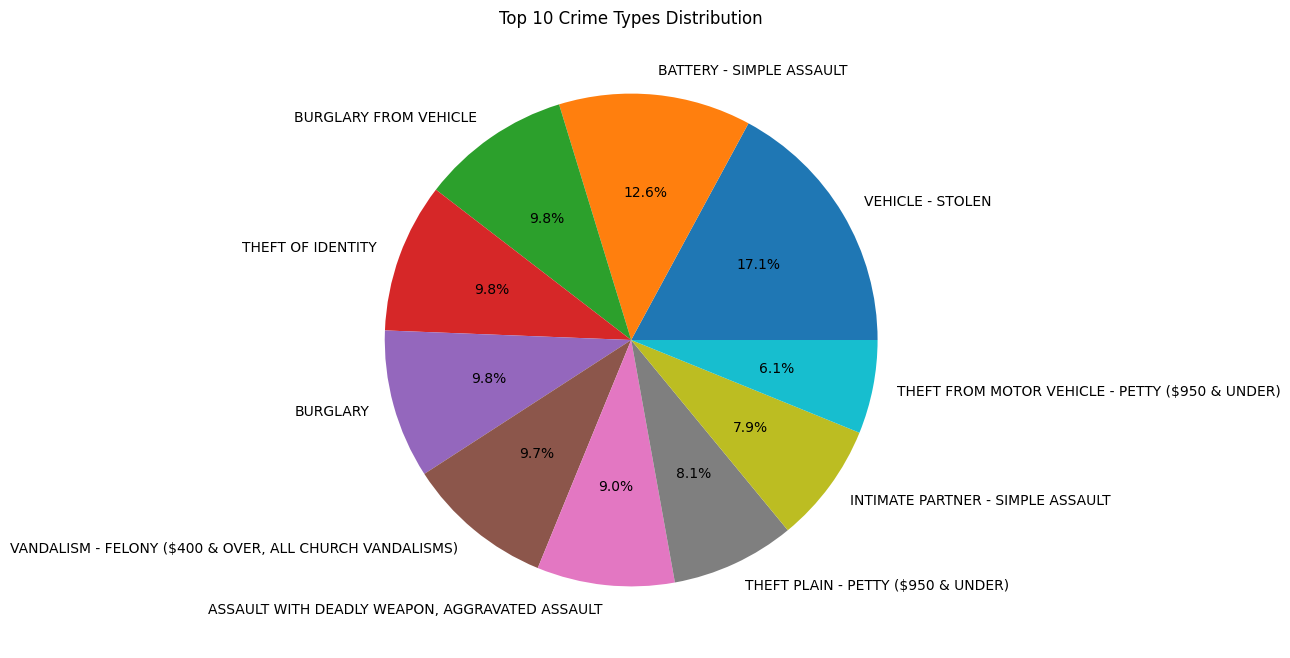

In [11]:
crime_type_counts = Data_new['Crm Cd Desc'].value_counts()
top_10_crime_types = crime_type_counts.head(10)
plt.figure(figsize=(8, 8))
plt.pie(top_10_crime_types, labels=top_10_crime_types.index, autopct='%1.1f%%')
plt.title('Top 10 Crime Types Distribution')
plt.show()

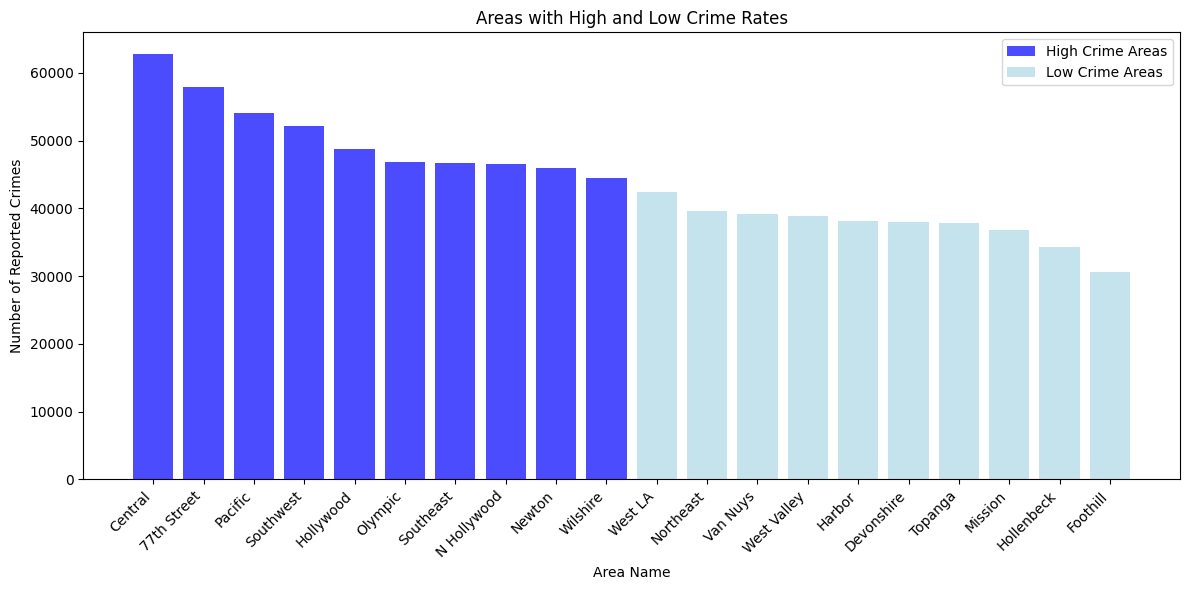

In [12]:

crime_by_area = Data_new['AREA NAME'].value_counts()
crime_by_area = crime_by_area.sort_values(ascending=False)
top_10_areas = crime_by_area.head(10)
bottom_10_areas = crime_by_area.tail(10)
plt.figure(figsize=(12, 6))
plt.bar(top_10_areas.index, top_10_areas.values, color='blue', alpha=0.7, label='High Crime Areas')
plt.bar(bottom_10_areas.index, bottom_10_areas.values, color='lightblue', alpha=0.7, label='Low Crime Areas')
plt.xlabel('Area Name')
plt.ylabel('Number of Reported Crimes')
plt.title('Areas with High and Low Crime Rates')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

In [13]:

fig = px.density_mapbox(Data_new.head(10000), lat = 'LAT', lon = 'LON', z = 'DR_NO',
                        radius = 8,
                        center = dict(lat =34.0545 , lon =   -118.3031),
                        zoom = 10,
                        mapbox_style = 'open-street-map',
                        width=1100,
                        height=800,
                        title="Heatmap of Crime Locations"
                        )

fig.show()

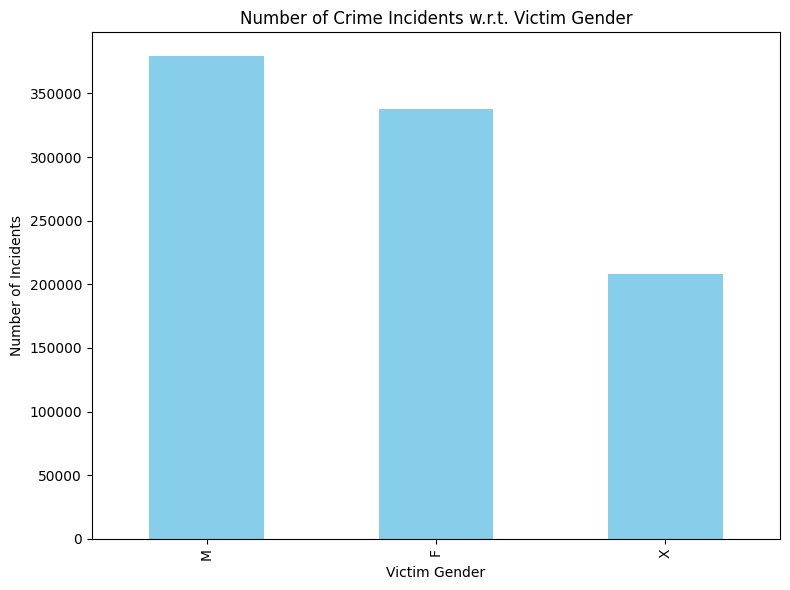

In [14]:

fig, ax = plt.subplots(figsize=(8, 6))
Data_new.groupby('Vict Sex')['Day'].count().sort_values(ascending=False).plot(kind='bar', ax=ax, color='skyblue', title='Crime Incidents by Victim Gender')
ax.set_ylabel('Number of Incidents')
ax.set_xlabel('Victim Gender')
plt.title('Number of Crime Incidents w.r.t. Victim Gender')
plt.tight_layout()
plt.show()


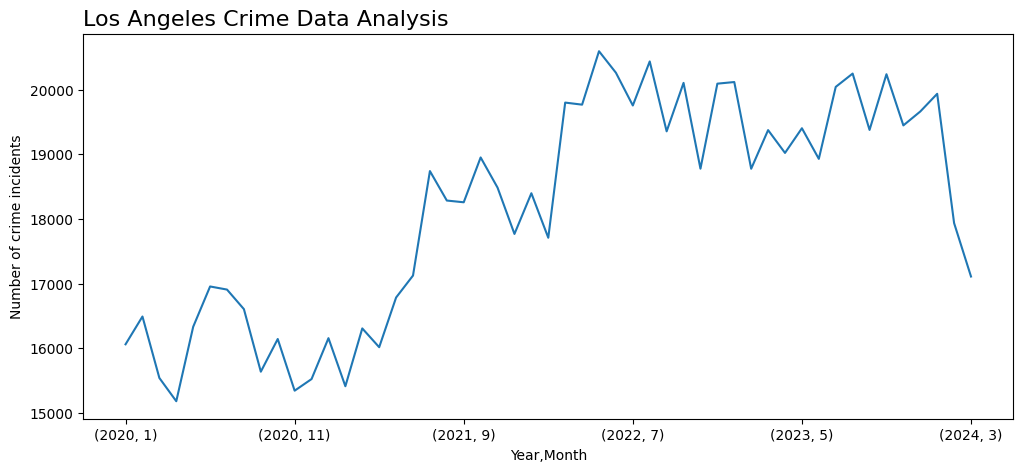

In [15]:
Data_new.groupby(['Year', 'Month'])['Day'].count().plot(kind='line', figsize=(12, 5))
plt.ylabel('Number of crime incidents')
plt.title('Los Angeles Crime Data Analysis', loc='left', fontsize=16)
plt.show()

<Axes: title={'center': 'Number of Crime Incidents over 12 Months'}, xlabel='Month'>

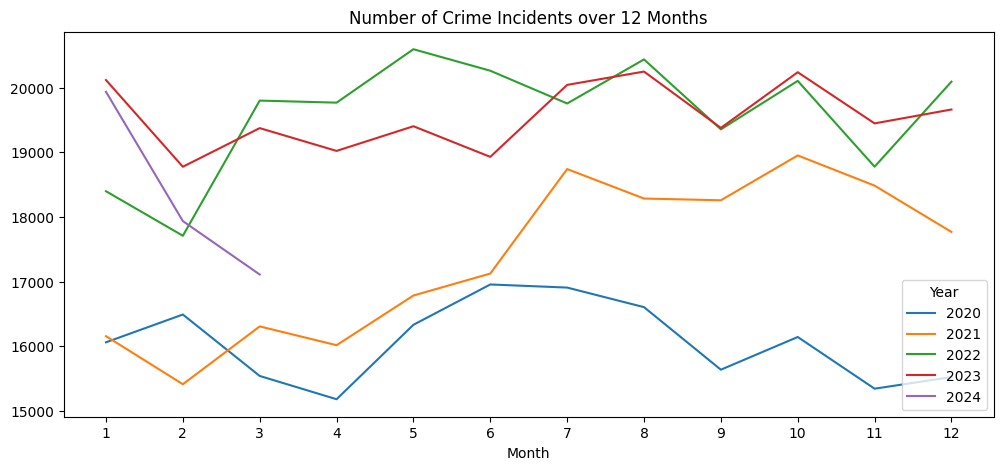

In [16]:
pltdata = Data_new.groupby(['Month', 'Year'])['Day'].count().unstack()
pltdata.plot(kind='line', figsize=(12, 5), xticks=range(1, 13), title='Number of Crime Incidents over 12 Months')

Is there any pattern of the number of crime incidents over the hour? Yes.

The number of crime incidents is the highest at noon (the lunch time). The second peak is around the dinner time.

Text(0.5, 1.0, 'Number of Crime Incidents over 24 Hours')

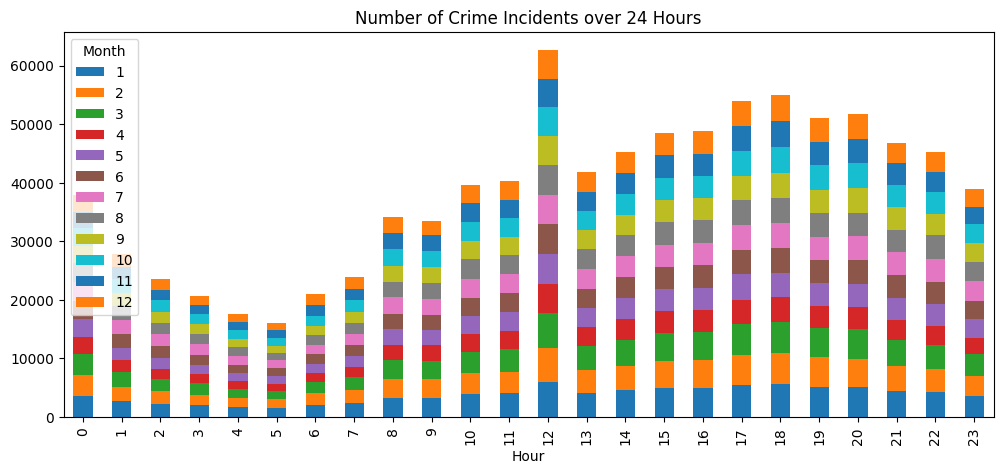

In [17]:
Data_new.groupby(['Hour', 'Month'])['Day'].count().unstack().plot(kind='bar', figsize=(12, 5), stacked=True)
plt.title('Number of Crime Incidents over 24 Hours')

#Analysis of 'Age'
It shows the number of the top five descents over ages. There are two exceptional peaks: age 50 for White and age 35 for Unknown. (More explanations are waiting for experts who know more about crimes.)

Text(0.5, 1.0, 'Number of Crime Incidents over Victim Descent')

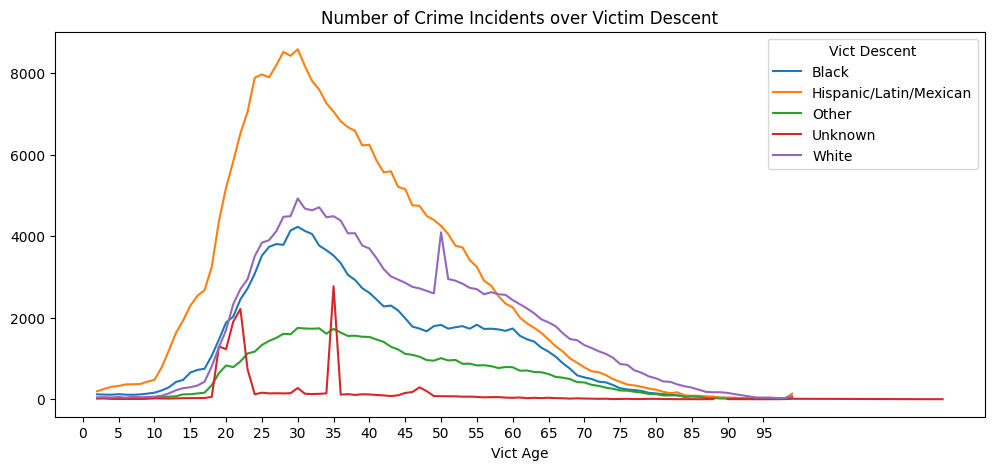

In [18]:
top5descents = Data_new.groupby(['Vict Descent'])['Day'].count().sort_values(ascending=False).index[:5]
data = Data_new[(Data_new['Vict Age']>0) & (Data_new['Vict Descent'].isin(top5descents))].copy()
vddict = {'B':'Black', 'H':'Hispanic/Latin/Mexican', 'O':'Other', 'W':'White', 'X':'Unknown'}
data['Vict Descent'] = data['Vict Descent'].apply(lambda x: vddict[x])

plt_data = data.groupby(['Vict Age', 'Vict Descent'])['Day'].count().unstack()
plt_data.plot(kind='line', figsize=(12, 5), xticks=range(0, 100, 5))
plt.title('Number of Crime Incidents over Victim Descent')

Text(0.5, 1.0, 'Number of Crime Incidents over Victim Ages')

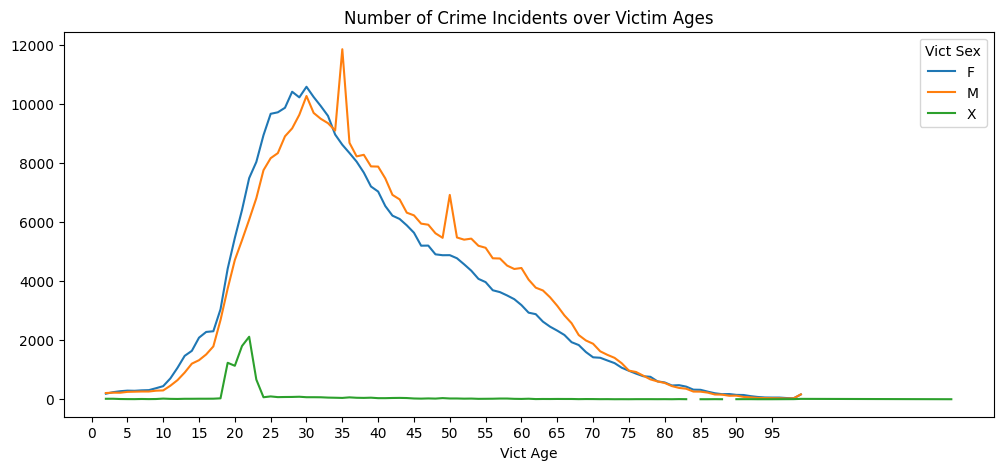

In [19]:
data = Data_new[(Data_new['Vict Age']>0)]
plt_data = data.groupby(['Vict Age', 'Vict Sex'])['Day'].count().unstack()
plt_data.plot(kind='line', figsize=(12, 5), xticks=range(0, 100, 5))
plt.title('Number of Crime Incidents over Victim Ages')

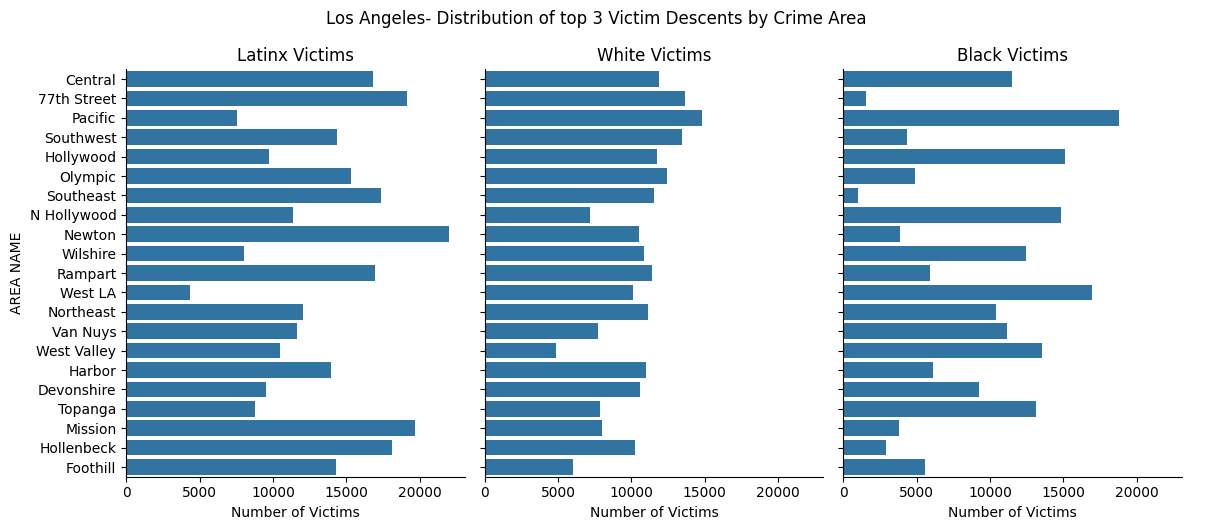

In [20]:
# Plotting a categorical estimate plot of Crime area by Descent
g = sns.catplot(y="AREA NAME", col="Vict Descent",
                col_order= Data_new['Vict Descent'].value_counts()[:3].index
                ,data=Data_new, kind="count",height=5, aspect=.8,
               order=Data_new['AREA NAME'].value_counts().index)

# Setting label an title for first facet
g.axes[0,0].set_xlabel('Number of Victims')
g.axes[0,0].set_title('Latinx Victims')

# Setting label an title for second facet
g.axes[0,1].set_xlabel('Number of Victims')
g.axes[0,1].set_title('White Victims')

# Setting label an title for third facet
g.axes[0,2].set_xlabel('Number of Victims')
g.axes[0,2].set_title('Black Victims')

#setting figure title for facetgrid plot
g.fig.suptitle('Los Angeles- Distribution of top 3 Victim Descents by Crime Area ', y = 1.05);

In [21]:
Data_new.reset_index(inplace=True)
Data_new['DATE OCC'] = pd.to_datetime(Data_new['DATE OCC'])
Data_new.set_index('DATE OCC', inplace=True)

monthly_crimes = Data_new.resample('MS').size()

# Optionally convert the Series to DataFrame
monthly_crimes_df = monthly_crimes.to_frame(name='crime_count')

# View the result
print(monthly_crimes_df.head())

<ipython-input-21-fca11c410879>:2: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



            crime_count
DATE OCC               
2020-01-01        18534
2020-02-01        17268
2020-03-01        16179
2020-04-01        15693
2020-05-01        17216


<Figure size 1400x700 with 0 Axes>

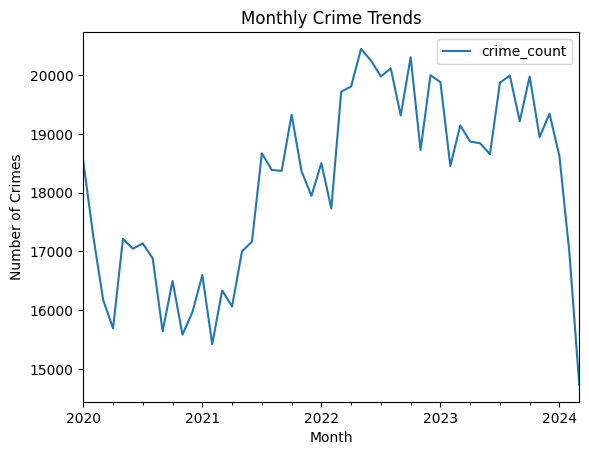

In [22]:
plt.figure(figsize=(14, 7))
monthly_crimes_df.plot()
plt.title('Monthly Crime Trends')
plt.xlabel('Month')
plt.ylabel('Number of Crimes')
plt.show()

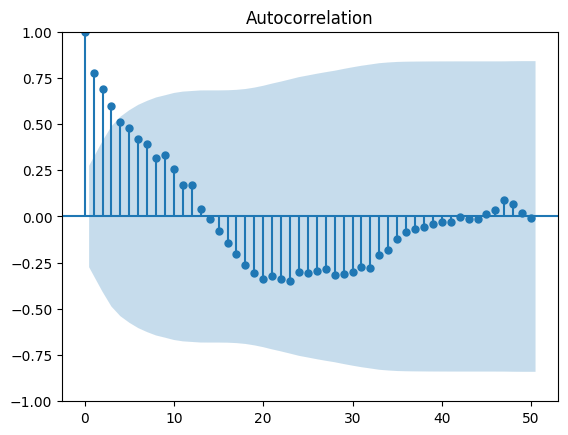

In [23]:

max_lags = min(100, len(monthly_crimes) - 1)
plot_acf(monthly_crimes_df, lags=max_lags, alpha=0.05)
plt.show()


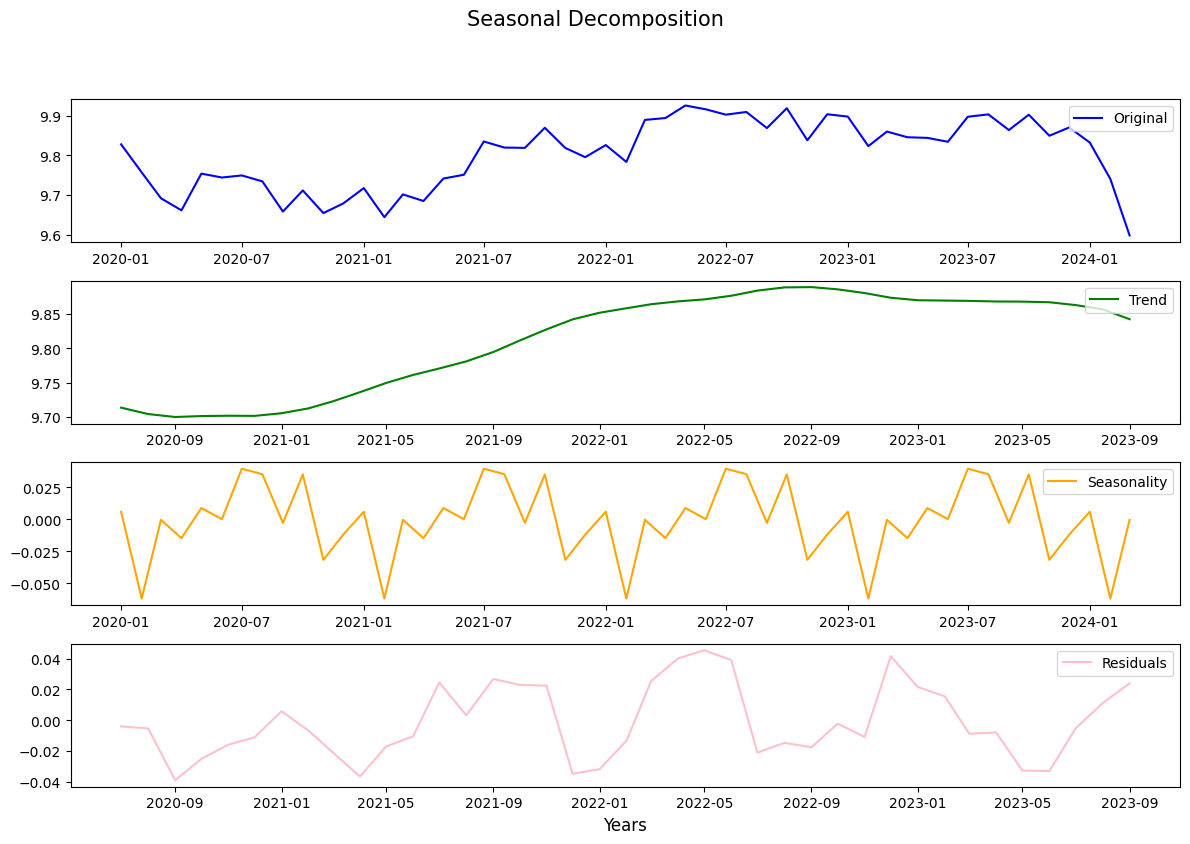

In [24]:

decomposition = seasonal_decompose(np.log(monthly_crimes_df))
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid


plt.figure(figsize=(12,8))
plt.suptitle('Seasonal Decomposition', y = 1.05, size = 15)

plt.subplot(411)
plt.plot(np.log(monthly_crimes_df), label='Original', color='blue')
plt.legend(loc=1)

plt.subplot(412)
plt.plot(trend, label='Trend', color='green')
plt.legend(loc=1)


plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='orange')
plt.legend(loc=1)

plt.subplot(414)
plt.plot(residual, label='Residuals', color='pink')
plt.legend(loc=1)
plt.xlabel('Years', size= 12)

plt.tight_layout()

In [25]:
# calculating rolling mean and rolling standard deviation
roll_mean = monthly_crimes_df.rolling(window=4, center=False).mean()
roll_std = monthly_crimes_df.rolling(window=4, center=False).std()

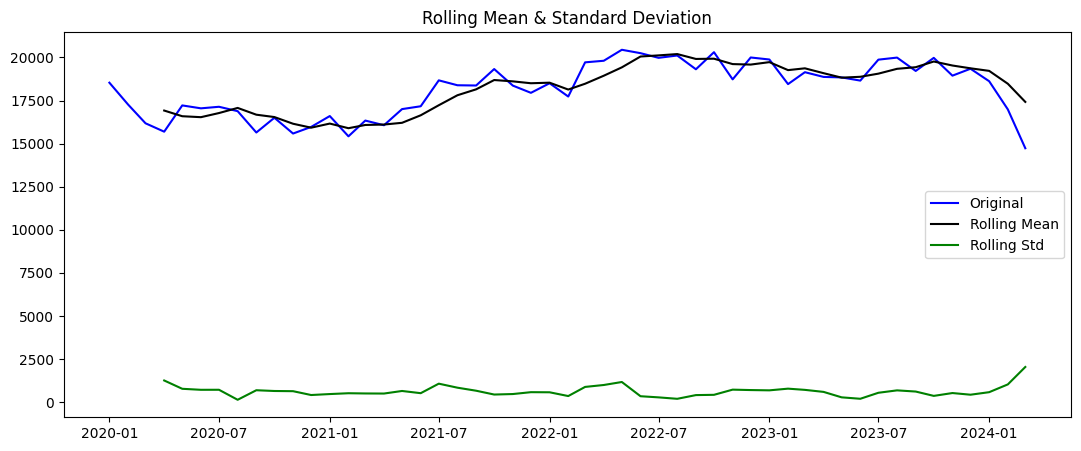

In [26]:
fig = plt.figure(figsize=(13,5))
plt.plot(monthly_crimes_df, color='blue', label='Original')
# rolling mean
plt.plot(roll_mean, color='black', label='Rolling Mean')
# standard deviation
plt.plot(roll_std, color='green', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [27]:
Xo = monthly_crimes_df.index
yo = monthly_crimes_df['crime_count']

train_seto = monthly_crimes_df.loc['2020-01-01':'2022-07-31']
test_seto = monthly_crimes_df.loc['2022-07-01' : '2024-01-01' ]

X_traino, X_testo = train_seto.index , test_seto.index
y_traino, y_testo = train_seto['crime_count'] , test_seto['crime_count']


In [28]:

p = d = q = range(0, 3)

# generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
# run a grid search with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(y_traino,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
        except:
            continue

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for

In [29]:
model = SARIMAX(y_traino,
                order=(1, 0, 2),              # Non-seasonal order
                seasonal_order=(2, 0, 1, 12))  # Reduced seasonal differencing
fitted_model = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [30]:
print(fitted_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                          crime_count   No. Observations:                   31
Model:             SARIMAX(1, 0, 2)x(2, 0, [1], 12)   Log Likelihood                -253.301
Date:                              Wed, 01 May 2024   AIC                            520.602
Time:                                      00:18:56   BIC                            530.640
Sample:                                  01-01-2020   HQIC                           523.874
                                       - 07-01-2022                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9969      0.061     16.241      0.000       0.877       1.117
ma.L1          0.06

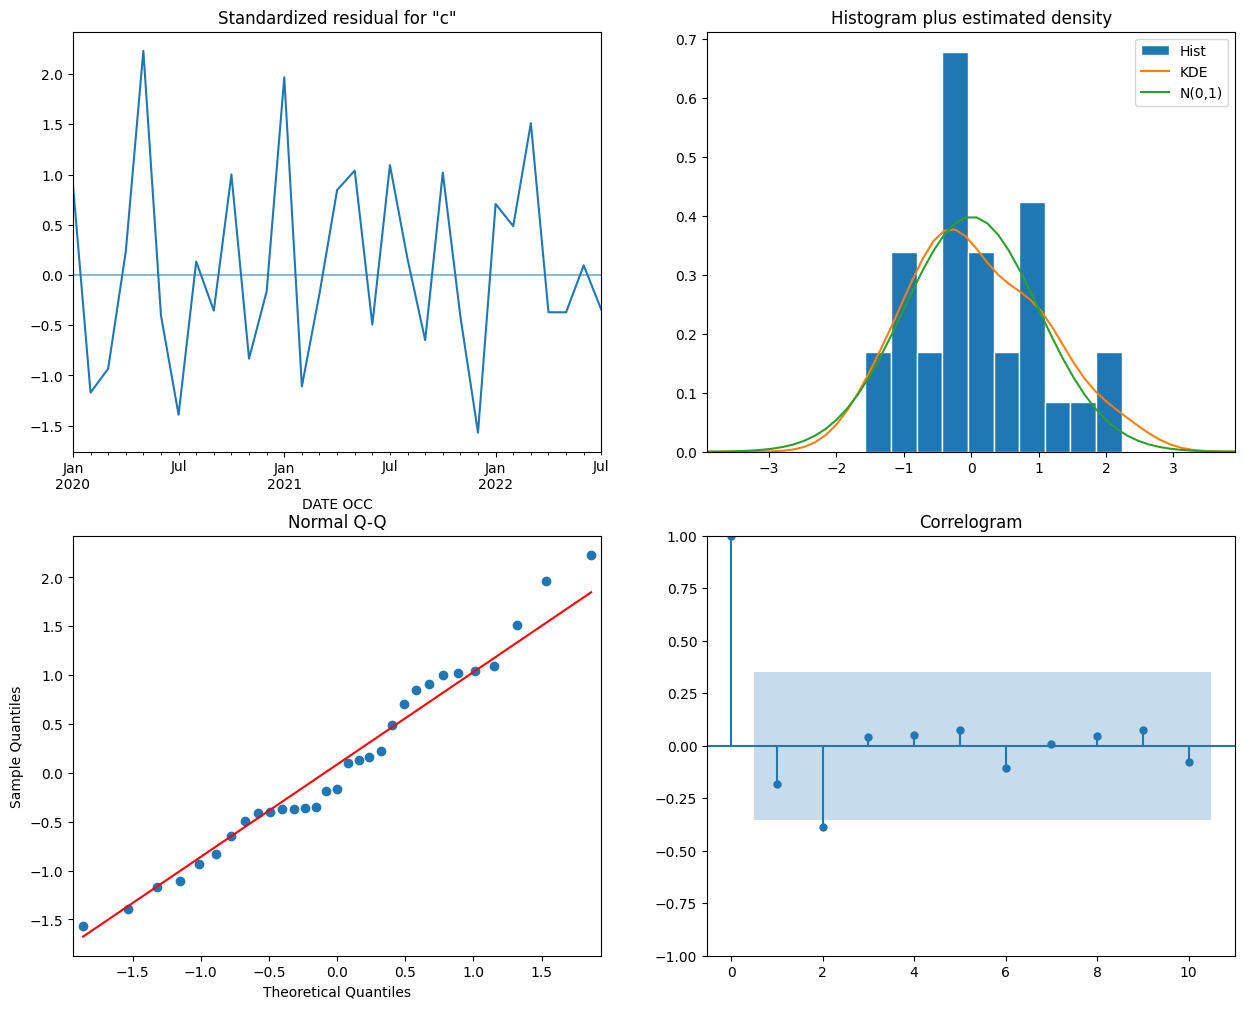

In [31]:
# Safely attempt to plot diagnostics
if len(fitted_model.resid) > 12:  # Ensure there are more residuals than the largest seasonal effect
    fitted_model.plot_diagnostics(figsize=(15, 12))
    plt.show()
else:
    print("Not enough data points for diagnostic plots.")


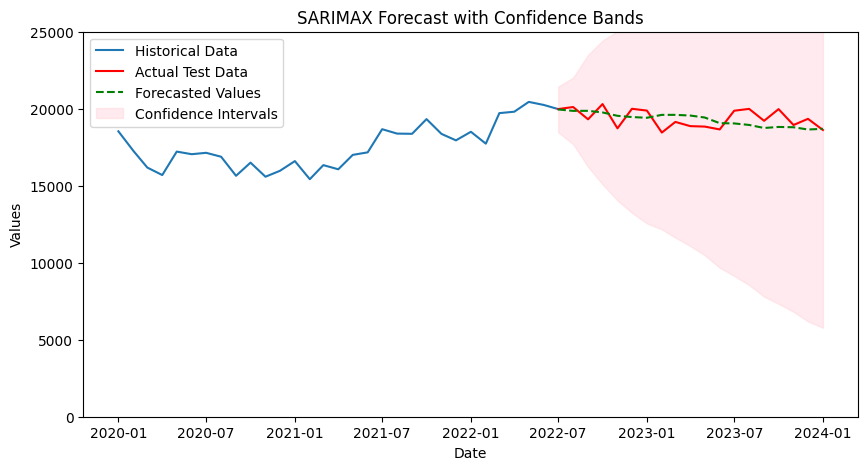

In [32]:
# Generate forecast for the test set period
forecast_result = fitted_model.get_forecast(steps=len(y_testo))
mean_forecast = forecast_result.predicted_mean
confidence_intervals = forecast_result.conf_int()


plt.figure(figsize=(10, 5))
plt.plot(y_traino.index, y_traino, label='Historical Data')

plt.plot(y_testo.index, y_testo, color='r', label='Actual Test Data')
plt.plot(y_testo.index, mean_forecast, color='green', linestyle='dashed', label='Forecasted Values')

plt.fill_between(y_testo.index,
                 confidence_intervals.iloc[:, 0],
                 confidence_intervals.iloc[:, 1], color='pink', alpha=0.3, label='Confidence Intervals')


plt.ylim(0, 25000)
plt.title('SARIMAX Forecast with Confidence Bands')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.show()


In [33]:

rmse = np.sqrt(mean_squared_error(y_testo, mean_forecast))
print("The Root Mean Squared Error of the forecasts is:", rmse)


The Root Mean Squared Error of the forecasts is: 656.3052606054399
